In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_labels(base_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(base_path):
        filepath = os.path.join(base_path, filename)
        if filepath.endswith(".png") and not "_mask" in filepath:
            images.append(filepath)
            labels.append(class_label)
    return images, labels

# Load benign and malignant images and masks
benign_images, benign_labels = load_images_and_labels("./Dataset_BUSI_with_GT/benign/", 0)
malignant_images, malignant_labels  = load_images_and_labels("./Dataset_BUSI_with_GT/malignant/", 1)

# Combine benign and malignant images and masks
images = benign_images + malignant_images
labels = benign_labels + malignant_labels

# Split the dataset into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, labels, img_width, img_height, is_augment=True):
        self.images = images
        self.labels = labels
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        mask = Image.open(self.images[index][:-4] + "_mask.png").resize((self.img_width, self.img_height))
        mask = np.array(mask, dtype=np.float32)
        label = torch.from_numpy(np.array(self.labels))[index].type(torch.LongTensor)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                mask = cv2.warpAffine(mask, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                mask = cv2.flip(mask, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])
        
        y_transform = transforms.Compose([
            ToLabel(),
        ])

        img_new = tfms(img_new)
        mask = y_transform(mask)

        return img_new, label, mask

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, labels_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, labels_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))

Training samples #:  517
Test samples #:  130


In [5]:
class ResNet50Multi(nn.Module):
    def __init__(self, n_classes):
        super(ResNet50Multi, self).__init__()

        # Load a pretrained ResNet50 model
        resnet50 = models.resnet50(pretrained=True)
        self.pool = resnet50.avgpool
        num_features = resnet50.fc.in_features  # Number of input features to the final fully connected layer
        self.classifier = torch.nn.Linear(num_features, 2)  # Replace the final fully connected layer

        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = nn.Sequential(*(list(resnet50.children())[0:3]))
        self.enc_features2 = nn.Sequential(*(list(resnet50.children())[3:5]))
        self.enc_features3 = nn.Sequential(*(list(resnet50.children())[5:6]))
        self.enc_features4 = nn.Sequential(*(list(resnet50.children())[6:7]))
        self.enc_features5 = nn.Sequential(*(list(resnet50.children())[7:8]))
        # Now, self.enc_features contains the encoder part of ResNet50

        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(2048, 1024)
        self.dec3 = self._make_dec_block(2048, 1024)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(1024, 512)
        self.dec2 = self._make_dec_block(1024, 512)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(512, 256)
        self.dec1 = self._make_dec_block(512, 256)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(256, 64)
        self.dec0 = self._make_dec_block(128, 64)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(64, 64)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x)  # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        # Decoder with skip connections
        x = self.upconv3(x5)
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3

        x = self.upconv2(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2

        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1

        x = self.upconv0(x)
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1

        x = self.upconv_final(x)
        
        # Classification
        
        cls = self.pool(x5)
        cls = cls.view(cls.size(0), -1)
        cls = self.classifier(cls)
        
        
        return cls, self.final_conv(x)

resnetmulti = ResNet50Multi(2)

/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import timm


# model = timm.create_model('swinv2_base_window8_256.ms_in1k', pretrained=True, num_classes=2)
swinv2 = timm.create_model('swinv2_cr_tiny_ns_224.sw_in1k', pretrained=True, num_classes=2)

In [7]:
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features  # Get the number of input features of the first layer in the classifier
new_classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 2)  # Change the out_features to 2 for binary classification
)
vgg16.classifier = new_classifier

/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
from models.vmamba import VSSM

is_pretrain = True

vmamba = VSSM(
    patch_size=4,
    in_chans=3,
    num_classes=1000,
    depths=[ 2, 2, 4, 2 ],
    dims=96,
    # ===================
    ssm_d_state=1,
    ssm_ratio=2.0,
    ssm_rank_ratio=2.0,
    ssm_dt_rank="auto",
    ssm_act_layer="silu",
    ssm_conv=3,
    ssm_conv_bias=False,
    ssm_drop_rate=0.0,
    ssm_init="v0",
    forward_type="v2",
    # ===================
    mlp_ratio=4.0,
    mlp_act_layer="gelu",
    mlp_drop_rate=0.0,
    # ===================
    drop_path_rate=0.2,
    patch_norm=True,
    norm_layer="ln",
    downsample_version="v3",
    patchembed_version="v2",
    use_checkpoint=False,
)
if is_pretrain:
    state_dict = torch.load('./pretrained/vssmtiny_dp02_ckpt_epoch_258.pth')['model']
    vmamba.load_state_dict(state_dict)

vmamba.classifier.head = torch.nn.Linear(in_features=768, out_features=2, bias=True)

In [9]:
from models.vmamba import VSSM

class MultiVmamba(nn.Module):
    def __init__(self, n_classes, is_pretrain):
        super(MultiVmamba, self).__init__()

        # Load a pretrained ResNet50 model
        vmamba = VSSM(
            patch_size=4,
            in_chans=3,
            num_classes=1000,
            depths=[ 2, 2, 4, 2 ],
            dims=96,
            # ===================
            ssm_d_state=1,
            ssm_ratio=2.0,
            ssm_rank_ratio=2.0,
            ssm_dt_rank="auto",
            ssm_act_layer="silu",
            ssm_conv=3,
            ssm_conv_bias=False,
            ssm_drop_rate=0.0,
            ssm_init="v0",
            forward_type="v2",
            # ===================
            mlp_ratio=4.0,
            mlp_act_layer="gelu",
            mlp_drop_rate=0.0,
            # ===================
            drop_path_rate=0.2,
            patch_norm=True,
            norm_layer="ln",
            downsample_version="v3",
            patchembed_version="v2",
            use_checkpoint=False,
        )
        if is_pretrain:
            state_dict = torch.load('./pretrained/vssmtiny_dp02_ckpt_epoch_258.pth')['model']
            vmamba.load_state_dict(state_dict)
        
       
        self.classifier = vmamba.classifier
        self.classifier[-1] = nn.Linear(in_features=768, out_features=2, bias=True)
        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = vmamba.patch_embed
        self.enc_features2 = vmamba.layers[0]
        self.enc_features3 = vmamba.layers[1]
        self.enc_features4 = vmamba.layers[2]
        self.enc_features5 = vmamba.layers[3]
        # Now, self.enc_features contains the encoder part of ResNet50
 
        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(768, 384)
        self.dec3 = self._make_dec_block(1536, 768)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(384, 192)
        self.dec2 = self._make_dec_block(768, 384)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(192, 96)
        self.dec1 = self._make_dec_block(384, 192)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(96, 96)
        self.dec0 = self._make_dec_block(192, 96)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(96, 96)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(96, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x) # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        
        
        cls = self.classifier(x5)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        x3 = x3.permute(0, 3, 1, 2)
        x4 = x4.permute(0, 3, 1, 2)
        x5 = x5.permute(0, 3, 1, 2)

        # Decoder with skip connections
        
        x = self.dec3(torch.cat([x5, x4], dim=1))  # Use skip connection from layer3
        x = self.upconv3(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2
        x = self.upconv2(x)

        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1
        x = self.upconv1(x)

        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1
        
        x = self.upconv0(x)

        x = self.upconv_final(x)
        

        
        return cls, self.final_conv(x)

vmambamulti = MultiVmamba(2, True)

In [10]:
resnet50 = models.resnet50(pretrained=True)

# Modify the final fully connected layer for binary classification
num_features = resnet50.fc.in_features  # Number of input features to the final fully connected layer
resnet50.fc = torch.nn.Linear(num_features, 2)  # Replace the final fully connected layer

/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
class MultiVGG16(nn.Module):
    def __init__(self, n_classes):
        super(MultiVGG16, self).__init__()

        # Load a pretrained ResNet50 model
        vgg16 = models.vgg16(pretrained=True)
        # vgg16 = models.vgg16(pretrained=True).features
        self.pool = vgg16.avgpool
        num_features = vgg16.classifier[0].in_features 
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2)  # Change the out_features to 2 for binary classification
        )

        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = nn.Sequential(*(list(vgg16.features.children())[0:5]))
        self.enc_features2 = nn.Sequential(*(list(vgg16.features.children())[5:10]))
        self.enc_features3 = nn.Sequential(*(list(vgg16.features.children())[10:17]))
        self.enc_features4 = nn.Sequential(*(list(vgg16.features.children())[17:24]))
        self.enc_features5 = nn.Sequential(*(list(vgg16.features.children())[24:]))

        # Decoder
        self.upconv3 = self._make_up_block(512, 512)
        self.dec3 = self._make_dec_block(1024, 512)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(512, 256)
        self.dec2 = self._make_dec_block(512, 256)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(256, 128)
        self.dec1 = self._make_dec_block(256, 128)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(128, 64)
        self.dec0 = self._make_dec_block(128, 64)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(64, 64)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x)  # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        
        # Segmentation
   
        # Decoder with skip connections
        x = self.upconv3(x5)
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3

        x = self.upconv2(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2

        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1

        x = self.upconv0(x)
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1

        x = self.upconv_final(x)
        
        # Classification
        
        cls = self.pool(x5)
        cls = cls.view(cls.size(0), -1)
        cls = self.classifier(cls)
        
        return cls, self.final_conv(x)

vgg16multi = MultiVGG16(2)

In [12]:
import timm

class MultiSwinV2Tiny(nn.Module):
    def __init__(self, n_classes, is_pretrain):
        super(MultiSwinV2Tiny, self).__init__()

        # Load a pretrained ResNet50 model
        swin_features = timm.create_model('swinv2_cr_tiny_ns_224.sw_in1k', pretrained=is_pretrain, num_classes=2)
        self.head = swin_features.head
        # print(self.head)
        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = swin_features.patch_embed
        self.enc_features2 = swin_features.stages[0]
        self.enc_features3 = swin_features.stages[1]
        self.enc_features4 = swin_features.stages[2]
        self.enc_features5 = swin_features.stages[3]
        # Now, self.enc_features contains the encoder part of ResNet50
 
        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(768, 384)
        self.dec3 = self._make_dec_block(768, 384)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(384, 192)
        self.dec2 = self._make_dec_block(384, 192)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(192, 96)
        self.dec1 = self._make_dec_block(192, 96)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(96, 96)
        self.dec0 = self._make_dec_block(192, 96)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(96, 96)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(96, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x) # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        
#         x1 = x1.permute(0, 3, 1, 2)
#         x2 = x2.permute(0, 3, 1, 2)
#         x3 = x3.permute(0, 3, 1, 2)
#         x4 = x4.permute(0, 3, 1, 2)
#         x5 = x5.permute(0, 3, 1, 2)
#         print(x1.shape)
#         print(x2.shape)
#         print(x3.shape)
#         print(x4.shape)
#         print(x5.shape)
        
        # Decoder with skip connections
        x = self.upconv3(x5)
        
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3
        
        x = self.upconv2(x)
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2
        
        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1
        x = self.upconv0(x)
        x = self.upconv_final(x)
        
        # Classification
        
        # print(x5.size(0))
        # cls = x5.view(x5.size(0), -1)
        cls = self.head(x5)
        
        return cls, self.final_conv(x)

swinmulti = MultiSwinV2Tiny(2, True)

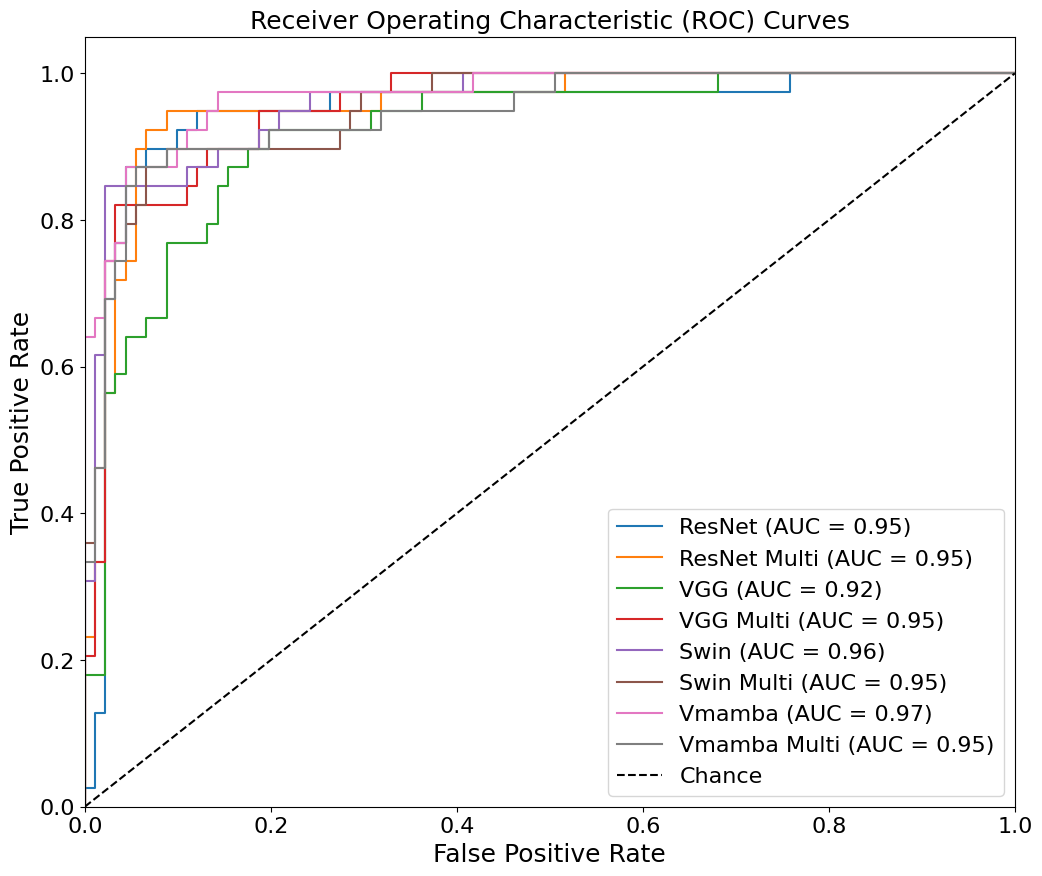

In [15]:
# from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix
# resnet = torch.load("./save_models/ResNet50_cls.pt")
# resnetmulti = torch.load("./save_models/ResNet50_Multi.pt")
# vgg = torch.load("./save_models/VGG16_cls.pt")
# vggmulti = torch.load("./save_models/VGG16_Multi.pt")
# swin = torch.load("./save_models/SwinV2Tiny_Multi.pt")
# swinmulti = torch.load("./save_models/Swin_Multi.pt")
# vmamba = torch.load("./save_models/Vmamba_cls.pt")
# vmambamulti = torch.load("./save_models/Vmamba_Multi.pt")
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# Assuming test_loader is defined and correctly loads your test dataset
# and that your models are loaded as shown in your question

models = {
    'ResNet': torch.load("./save_models/ResNet50_cls.pt"),
    'ResNet Multi': torch.load("./save_models/ResNet50_Multi.pt"),
    'VGG': torch.load("./save_models/VGG16_cls.pt"),
    'VGG Multi': torch.load("./save_models/VGG16_Multi.pt"),
    'Swin': torch.load("./save_models/SwinV2Tiny_cls.pt"),
    'Swin Multi': torch.load("./save_models/Swin_Multi.pt"),
    'Vmamba': torch.load("./save_models/Vmamba_cls.pt"),
    'Vmamba Multi': torch.load("./save_models/Vmamba_Multi.pt")
}

# Ensure all models are in evaluation mode and move them to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in models.values():
    model.eval()
    model.to(device)

# Calculate predictions and true labels for each model
model_outputs = {name: [] for name in models}
true_labels = []

with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        true_labels.extend(labels.cpu().numpy())
        for name, model in models.items():
            raw_outputs = model(inputs)
            # Handle multi-task model outputs
            outputs = raw_outputs[0] if isinstance(raw_outputs, tuple) else raw_outputs
            # Apply softmax and use the probability of the positive class
            probs = softmax(outputs, dim=1).cpu().numpy()[:, 1]
            model_outputs[name].extend(probs)

# Compute ROC curve and ROC area for each model
plt.figure(figsize=(12, 10))
for name, outputs in model_outputs.items():
    fpr, tpr, _ = roc_curve(true_labels, outputs)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)  # Increased font size
plt.ylabel('True Positive Rate', fontsize=18)  # Increased font size
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=18)  # Increased font size
plt.legend(loc="lower right", fontsize=16)  # Increased font size
plt.xticks(fontsize=16)  # Increased font size for tick labels
plt.yticks(fontsize=16)  # Increased font size for tick labels
plt.show()

